# METEOCPY Intro 2 -- Save and Visualize

## Imports

In [11]:
PATH = '/Users/jim' # replace with the parent director of your meteocpy installation
DATA_PATH = '/Users/jim/meteoc' # replace with the parent directory of where you installed data and params

In [12]:
import sys
sys.path.append(PATH)

In [13]:
import meteocpy as mpy
from meteocpy.forward import apex
from meteocpy import utils
from meteocpy.utils import load_params, BiDict

import numpy as np
import os
import matplotlib.pyplot as plt
from os.path import join as pjoin

from importlib import reload

In [14]:
%matplotlib inline

In [15]:
# if you change the code and want to run it here with your changes, run this cell first!
reload(apex)
reload(utils)

<module 'meteocpy.utils' from '/Users/jim/meteocpy/utils.py'>

## Plotting prep

In [26]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [41]:
def plot_frame(res, ind, channel=0, vmax=None, vmin=None, figsize=None, binned='binned'):
    tostr = lambda f: "%.2f" % f
    
    wvls_nr = ap.params[binned].cw[illu_bands[ind]].mean(axis=1)
    wvls = list(map(tostr, wvls_nr))
    
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    
    im = axs[0].matshow(res[ind][channel], aspect='auto', vmax=vmax, vmin=vmin, 
                        extent=[0, 1000, wvls_nr[-1], wvls_nr[0]])
    
    divider = make_axes_locatable(axs[0])
    cax = divider.append_axes('right', size='1%', pad=0.05)
    plt.gcf().colorbar(im, cax=cax)
    
    axs[1].plot(wvls, res[ind][channel][:, [250, 500, 750]], '-o')
    axs[1].set_ylim([np.min(res[ind][channel][:, [250, 500, 750]]) * 0.9, np.max(res[ind][channel][:, [250, 500, 750]]) * 1.1])

## Prepare and simulate

In [16]:
# Instantiate a sensor from the SRF parameterization and meta variables (see directory for an example)
ap = apex.load_apex(unbinned_vnir=pjoin(DATA_PATH, 'params/unbinned'),
                    binned_vnir_swir=pjoin(DATA_PATH,'params/binned'),
                    binned_meta=pjoin(DATA_PATH,'params/binned_meta'), 
                    vnir_it=27000, swir_it=15000)

/Users/jim/meteocpy/forward/apex.py:123: UserWarning: WARNING: you loaded unbinned calibration files but meta files are binned. Make sure tocall initialize_srfs with kwarg do_bin=True.
  warnings.warn('WARNING: you loaded unbinned calibration files but meta files are binned. Make sure to'


In [17]:
# init SRFs
init_wvls = np.arange(600, 700, 0.01)
ap.initialize_srfs(exact_wvls=init_wvls, 
                   srf_support_in_sigma=3,
                   do_bin=True)

In [18]:
# define simulation params
# configure simulation
simu_config = dict(pad=False, # whether to return the whole frame or 
                              # only illuminated spectral bands? (note no dc in in non illuminated bands)
                   
                   part_covered=True, # criterion for a band to be illuminated: overlapping supports is enough
                   
                   invert=True, # simulation steps
                   snr=True, 
                   dc=True, 
                   smear=True, 
                   
                   return_binned=False, # binning after forward simulaton is currently not implemented
                                        # this should actually be done for physical correctness
                   
                   run_specs=dict(joblib=False, # joblib activates parallel executuion
                                  n_jobs=4, # how many cores
                                  batches_per_job=3 , # how many batches per core
                                  ),
                   
                   conv_mode='numba' # whether to use the numba library for convolution (best leave that)
                  )

In [19]:
# Try a simulation with multiple batches and channels, shape [(1, 3), (2, 7), (4, 1)]. 
# Pay attention to the shapes. Batch dim is not well-defined because we're simulating 
# with differently sized inp_spectra. So the batch dimension has to be a list (which doesn't
# require identical shapes of its elements). Inside the list we have arrays with (channel, wvl).

inp_spectrum = [np.array([1e4, 1e5, 1e6]).reshape(1, -1), # note: this is equal to np.array([[1e4, 1e5, 1e6]])
                np.array([[1e6, 1e6, 1e6, 1e5, 1e6, 1e6, 1e4], 
                          [.5e6, .5e6, .5e6, .2e5, .1e6, .1e6, .1e4]]),
                np.array([1e3, 1e4, 1e5, 1e6]).reshape(-1, 1)]


inp_wvls = [np.arange(650, 653, 1), # the support has to have len 3
            np.arange(673, 680, 1), # the support has to have len 7
            np.array([697])] # the support has to have len 1

res, illu_bands = ap.forward(inp_spectrum=inp_spectrum, inp_wvlens=inp_wvls, **simu_config)

/Users/jim/miniconda3/envs/meteocpy/lib/python3.6/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'weights_per_band' of function 'convolve_non_aligned'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../forward/apex.py", line 17:
@nb.jit(nopython=True)
def convolve_non_aligned(inp, weights=None, weights_per_band=None,
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


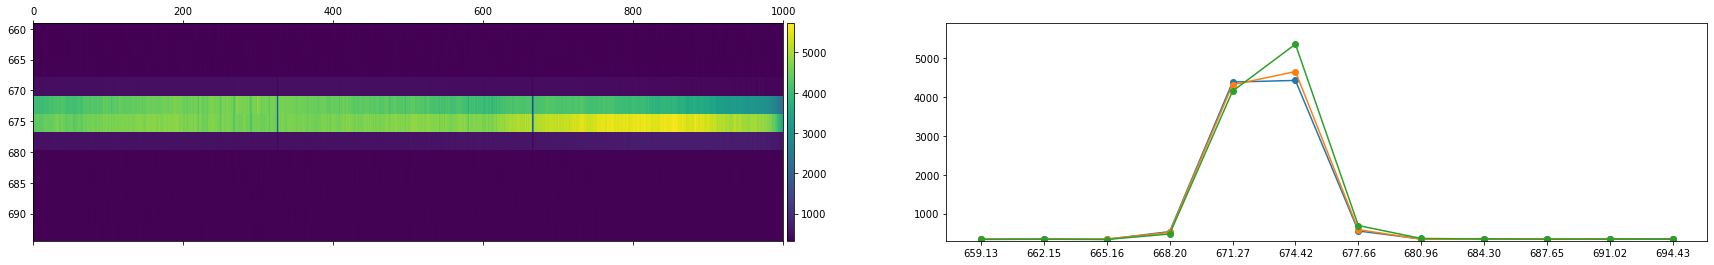

In [40]:
%matplotlib inline
inds = [1]
channel = 1
for ind in inds:
    plot_frame(res, ind, channel=channel, vmax=None, vmin=None, figsize=(30, 4), binned='binned')